In [44]:
path=r'C:\Users\ASUS\Desktop\PBL\data\resampled_dataset.csv'

CNN-lstm after reducing overfitting 

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        # First Conv1D block
        Conv1D(filters=32, kernel_size=3, activation='relu', 
               kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        # Second Conv1D block
        Conv1D(filters=64, kernel_size=3, activation='relu',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        # Optimized single LSTM layer (no recurrent dropout for speed)
        LSTM(64, dropout=0.3),
        
        # Dense layer
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        
        # Output layer with float32 (for mixed precision compatibility)
        Dense(num_classes, activation='softmax', dtype='float32')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [46]:
def preprocess_data(X, y, test_size=0.2, val_size=0.2):
    """Preprocess data: scale features and split into train, test, validation sets"""
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        stratify=y, random_state=42)
    
    # Split train set into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, 
                                                      stratify=y_train, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # Reshape for CNN (samples, timesteps, features)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def data_augmentation(X, y):
    """Apply data augmentation to increase dataset size and variety"""
    X_augmented = [X]
    y_augmented = [y]
    
    # Adding random noise
    noise_factor = 0.05
    X_noise = X + np.random.normal(0, noise_factor, X.shape)
    X_augmented.append(X_noise)
    y_augmented.append(y)
    
    # Magnitude scaling
    scale_factor = np.random.uniform(0.8, 1.2)
    X_scaled = X * scale_factor
    X_augmented.append(X_scaled)
    y_augmented.append(y)
    
    # Time shifting
    shift = np.random.randint(1, 3)
    X_shifted = np.roll(X, shift, axis=1)
    X_augmented.append(X_shifted)
    y_augmented.append(y)
    
    # Combine augmented data
    X_aug = np.vstack(X_augmented)
    y_aug = np.hstack(y_augmented)
    
    # Shuffle the augmented data
    indices = np.arange(X_aug.shape[0])
    np.random.shuffle(indices)
    X_aug = X_aug[indices]
    y_aug = y_aug[indices]
    
    return X_aug, y_aug


In [47]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    """
    Focal loss for dealing with class imbalance
    """
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) - \
               K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed


In [48]:
def train_model(X_train, y_train, X_val, y_val, input_shape, num_classes, 
                batch_size=64, epochs=50, use_focal_loss=False):
    """Train the CNN-LSTM model with all overfitting prevention techniques"""
    
    # Apply data augmentation to increase training data diversity
    X_train_aug, y_train_aug = data_augmentation(X_train, y_train)
    
    # Calculate class weights for imbalanced data
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    # Create model
    model = create_cnn_lstm_model(input_shape, num_classes)
    
    # Use focal loss for imbalanced data if specified
    if use_focal_loss:
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss=focal_loss(),
            metrics=['accuracy']
        )
    
    # Print model summary
    model.summary()
    
    # Define callbacks for early stopping and learning rate reduction
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True, 
            verbose=1
        ),
        
        # Learning rate scheduler - reduce learning rate when stuck
        ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=5, 
            min_lr=1e-6, 
            verbose=1
        ),
        
        # Model checkpoint to save best model
        ModelCheckpoint(
            'best_model.h5', 
            monitor='val_loss', 
            save_best_only=True, 
            verbose=1
        )
    ]
    
    # Train the model
    history = model.fit(
        X_train_aug, y_train_aug,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    return model, history


In [49]:
def evaluate_model(model, X_test, y_test):
    """Evaluate model performance and visualize results"""
    
    # Predict on test data
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Print classification report
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Calculate test accuracy
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_accuracy:.4f}")
    
def plot_training_history(history):
    """Plot training and validation metrics"""
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [50]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [51]:
#Load dataset
df = pd.read_csv(path)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,286370,2,2,80,266,40,40,40.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,53,741,2,2,54,178,27,27,27.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,53,31410,2,2,60,174,30,30,30.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,53551,4748,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,443,5661084,7,4,635,168,517,0,90.714286,190.707205,...,32,153901.0,0.0,153901,153901,5507135.0,0.0,5507135,5507135,BENIGN


In [52]:
df.shape

(746117, 79)

In [53]:
df.describe()

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,746117.000000,7.461170e+05,746117.000000,746117.000000,7.461170e+05,7.461170e+05,746117.000000,746117.000000,746117.000000,746117.000000,...,746117.000000,7.461170e+05,7.461170e+05,7.461170e+05,7.461170e+05,7.461170e+05,7.461170e+05,7.461170e+05,7.461170e+05,7.461170e+05
mean,5195.159152,2.214381e+07,7.664345,8.040212,3.897068e+02,1.392028e+04,165.624361,10.679005,43.385936,59.359873,...,3.998023,-1.412403e+03,9.285406e+04,3.060680e+04,1.367981e+05,7.423070e+04,1.764452e+07,1.009668e+06,1.841303e+07,1.690483e+07
std,14144.686896,3.898666e+07,673.933537,877.181297,6.668536e+03,2.130323e+06,579.066493,55.480015,154.968748,226.631737,...,536.762287,8.789839e+05,6.836524e+05,3.546173e+05,9.355221e+05,6.322933e+05,3.457368e+07,6.819789e+06,3.546375e+07,3.438408e+07
min,0.000000,-1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,80.000000,6.500000e+01,1.000000,1.000000,2.000000e+00,0.000000e+00,2.000000,0.000000,2.000000,0.000000,...,0.000000,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,80.000000,4.823000e+04,2.000000,2.000000,3.100000e+01,9.900000e+01,20.000000,0.000000,8.666667,0.000000,...,1.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,445.000000,1.134768e+07,6.000000,5.000000,3.170000e+02,1.159500e+04,274.000000,6.000000,47.750000,89.882516,...,2.000000,3.200000e+01,1.770000e+02,0.000000e+00,1.770000e+02,1.070000e+02,9.367733e+06,0.000000e+00,9.720346e+06,7.230865e+06
max,65529.000000,1.200000e+08,206446.000000,276072.000000,2.321478e+06,6.270000e+08,24820.000000,2065.000000,5940.857143,7049.469004,...,192326.000000,1.380000e+02,1.030000e+08,4.230000e+07,1.030000e+08,1.030000e+08,1.200000e+08,7.350000e+07,1.200000e+08,1.200000e+08


In [54]:
df.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [55]:
df.isnull().sum()
df.isna().sum()

Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 79, dtype: int64

In [56]:
df['Label'].value_counts()

Label
BENIGN                        300000
DoS Hulk                      184858
PortScan                      127144
DDoS                          102422
DoS GoldenEye                   8234
FTP-Patator                     6350
SSH-Patator                     4718
DoS slowloris                   4637
DoS Slowhttptest                4399
Bot                             1573
Web Attack � Brute Force        1205
Web Attack � XSS                 522
Infiltration                      29
Web Attack � Sql Injection        17
Heartbleed                         9
Name: count, dtype: int64

In [57]:
# Define mapping dictionary
label_mapping = {
    'BENIGN': 'Benign Traffic',
    'DoS Hulk': 'DoS Attacks',
    'DoS GoldenEye': 'DoS Attacks',
    'DoS slowloris': 'DoS Attacks',
    'DoS Slowhttptest': 'DoS Attacks',
    'DDoS': 'DDoS Attacks',
    'PortScan': 'Port Scanning & Brute Force',
    'FTP-Patator': 'Port Scanning & Brute Force',
    'SSH-Patator': 'Port Scanning & Brute Force',
    'Web Attack – Brute Force': 'Web-Based Attacks',
    'Web Attack – XSS': 'Web-Based Attacks',
    'Web Attack – Sql Injection': 'Web-Based Attacks',
    'Bot': 'Other Exploits & Infiltrations',
    ' Infiltration': 'Other Exploits & Infiltrations',
    'Heartbleed': 'Other Exploits & Infiltrations'
}

# Apply mapping to create a new column with grouped labels
df['Label'] = df['Label'].map(label_mapping)
df['Label'].value_counts()


Label
Benign Traffic                    300000
DoS Attacks                       202128
Port Scanning & Brute Force       138212
DDoS Attacks                      102422
Other Exploits & Infiltrations      1582
Name: count, dtype: int64

In [58]:
df.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [59]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the grouped labels
df['Label'] = label_encoder.fit_transform(df['Label'])

In [60]:
df['Label'].value_counts()

Label
0    300000
2    202128
4    138212
1    102422
5      1773
3      1582
Name: count, dtype: int64

In [61]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Convert inf to NaN

df.fillna(df.median(), inplace=True)  # Replace NaN with max finite value


<Axes: title={'center': 'Count (target)'}, xlabel='Label'>

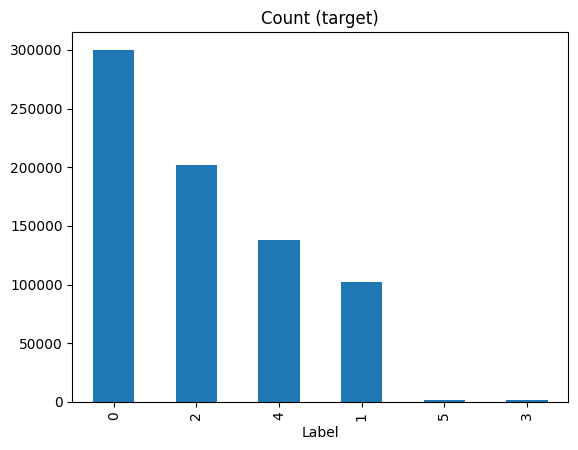

In [62]:
df['Label'].value_counts().plot(kind='bar', title='Count (target)')

In [63]:
# Normalize features
scaler = MinMaxScaler()

X = df.drop(columns=['Label']).values
X_scaled = scaler.fit_transform(X)
y = df['Label'].values
y_encoded = to_categorical(y)

Training set shape: (477514, 78, 1)
Validation set shape: (119379, 78, 1)
Test set shape: (149224, 78, 1)
Number of classes: 6
Class distribution in training set: [192000  65550 129362   1013  88455   1134]


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 76, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 76, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 38, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 38, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 36, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 18, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,550 (174.02 KB)

 Trainable params: 44,230 (172.77 KB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/50
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7719 - loss: 0.6197
Epoch 1: val_loss improved from inf to 0.45749, saving model to best_model.h5


29845/29845 ━━━━━━━━━━━━━━━━━━━━ 232s 8ms/step - accuracy: 0.7719 - loss: 0.6197 - val_accuracy: 0.8808 - val_loss: 0.4575 - learning_rate: 0.0010
Epoch 2/50
29841/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9107 - loss: 0.2403
Epoch 2: val_loss improved from 0.45749 to 0.33086, saving model to best_model.h5


29845/29845 ━━━━━━━━━━━━━━━━━━━━ 226s 8ms/step - accuracy: 0.9107 - loss: 0.2403 - val_accuracy: 0.9210 - val_loss: 0.3309 - learning_rate: 0.0010
Epoch 3/50
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9258 - loss: 0.2070
Epoch 3: val_loss improved from 0.33086 to 0.24485, saving model to best_model.h5


29845/29845 ━━━━━━━━━━━━━━━━━━━━ 233s 8ms/step - accuracy: 0.9258 - loss: 0.2070 - val_accuracy: 0.9280 - val_loss: 0.2449 - learning_rate: 0.0010
Epoch 4/50
29842/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9301 - loss: 0.1930
Epoch 4: val_loss did not improve from 0.24485
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 228s 8ms/step - accuracy: 0.9301 - loss: 0.1930 - val_accuracy: 0.9289 - val_loss: 0.2516 - learning_rate: 0.0010
Epoch 5/50
29841/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9334 - loss: 0.1807
Epoch 5: val_loss did not improve from 0.24485
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 231s 8ms/step - accuracy: 0.9334 - loss: 0.1807 - val_accuracy: 0.9363 - val_loss: 0.2583 - learning_rate: 0.0010
Epoch 6/50
29839/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9351 - loss: 0.1776
Epoch 6: val_loss did not improve from 0.24485
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 230s 8ms/step - accuracy: 0.9351 - loss: 0.1776 - val_accuracy: 0.9356 - val_loss: 0.2592 - learning_rate: 0.0010
E

29845/29845 ━━━━━━━━━━━━━━━━━━━━ 241s 8ms/step - accuracy: 0.9369 - loss: 0.1741 - val_accuracy: 0.9415 - val_loss: 0.2376 - learning_rate: 0.0010
Epoch 9/50
29843/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9389 - loss: 0.1684
Epoch 9: val_loss improved from 0.23759 to 0.23275, saving model to best_model.h5


29845/29845 ━━━━━━━━━━━━━━━━━━━━ 239s 8ms/step - accuracy: 0.9389 - loss: 0.1684 - val_accuracy: 0.9464 - val_loss: 0.2327 - learning_rate: 0.0010
Epoch 10/50
29843/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9392 - loss: 0.1704
Epoch 10: val_loss did not improve from 0.23275
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 242s 8ms/step - accuracy: 0.9392 - loss: 0.1704 - val_accuracy: 0.9234 - val_loss: 0.2757 - learning_rate: 0.0010
Epoch 11/50
29842/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9399 - loss: 0.1665
Epoch 11: val_loss did not improve from 0.23275
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 239s 8ms/step - accuracy: 0.9399 - loss: 0.1665 - val_accuracy: 0.9417 - val_loss: 0.2352 - learning_rate: 0.0010
Epoch 12/50
29844/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9397 - loss: 0.1719
Epoch 12: val_loss did not improve from 0.23275
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 246s 8ms/step - accuracy: 0.9397 - loss: 0.1719 - val_accuracy: 0.9091 - val_loss: 0.2720 - learning_rate: 0.

29845/29845 ━━━━━━━━━━━━━━━━━━━━ 240s 8ms/step - accuracy: 0.9397 - loss: 0.1680 - val_accuracy: 0.9525 - val_loss: 0.2011 - learning_rate: 0.0010
Epoch 14/50
29840/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9404 - loss: 0.1703
Epoch 14: val_loss did not improve from 0.20111
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 231s 8ms/step - accuracy: 0.9404 - loss: 0.1703 - val_accuracy: 0.9415 - val_loss: 0.2531 - learning_rate: 0.0010
Epoch 15/50
29839/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9421 - loss: 0.1630
Epoch 15: val_loss did not improve from 0.20111
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 239s 8ms/step - accuracy: 0.9421 - loss: 0.1630 - val_accuracy: 0.9465 - val_loss: 0.2164 - learning_rate: 0.0010
Epoch 16/50
29841/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9419 - loss: 0.1610
Epoch 16: val_loss did not improve from 0.20111
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 236s 8ms/step - accuracy: 0.9419 - loss: 0.1610 - val_accuracy: 0.9405 - val_loss: 0.2263 - learning_rate: 0.

29845/29845 ━━━━━━━━━━━━━━━━━━━━ 248s 8ms/step - accuracy: 0.9454 - loss: 0.1478 - val_accuracy: 0.9518 - val_loss: 0.1928 - learning_rate: 5.0000e-04
Epoch 20/50
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9495 - loss: 0.1271
Epoch 20: val_loss did not improve from 0.19275
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 238s 8ms/step - accuracy: 0.9495 - loss: 0.1271 - val_accuracy: 0.9450 - val_loss: 0.2195 - learning_rate: 5.0000e-04
Epoch 21/50
29839/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9484 - loss: 0.1290
Epoch 21: val_loss improved from 0.19275 to 0.17561, saving model to best_model.h5


29845/29845 ━━━━━━━━━━━━━━━━━━━━ 246s 8ms/step - accuracy: 0.9484 - loss: 0.1290 - val_accuracy: 0.9518 - val_loss: 0.1756 - learning_rate: 5.0000e-04
Epoch 22/50
29842/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9492 - loss: 0.1258
Epoch 22: val_loss did not improve from 0.17561
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 242s 8ms/step - accuracy: 0.9492 - loss: 0.1258 - val_accuracy: 0.9489 - val_loss: 0.1885 - learning_rate: 5.0000e-04
Epoch 23/50
29840/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9498 - loss: 0.1255
Epoch 23: val_loss did not improve from 0.17561
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 253s 8ms/step - accuracy: 0.9498 - loss: 0.1255 - val_accuracy: 0.9426 - val_loss: 0.1998 - learning_rate: 5.0000e-04
Epoch 24/50
29842/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9500 - loss: 0.1247
Epoch 24: val_loss did not improve from 0.17561
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 250s 8ms/step - accuracy: 0.9500 - loss: 0.1247 - val_accuracy: 0.9515 - val_loss: 0.1817 - learn

29845/29845 ━━━━━━━━━━━━━━━━━━━━ 261s 9ms/step - accuracy: 0.9529 - loss: 0.1121 - val_accuracy: 0.9580 - val_loss: 0.1463 - learning_rate: 2.5000e-04
Epoch 28/50
29844/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9548 - loss: 0.1036
Epoch 28: val_loss improved from 0.14629 to 0.14552, saving model to best_model.h5


29845/29845 ━━━━━━━━━━━━━━━━━━━━ 244s 8ms/step - accuracy: 0.9548 - loss: 0.1036 - val_accuracy: 0.9550 - val_loss: 0.1455 - learning_rate: 2.5000e-04
Epoch 29/50
29840/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9548 - loss: 0.1029
Epoch 29: val_loss did not improve from 0.14552
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 253s 8ms/step - accuracy: 0.9548 - loss: 0.1029 - val_accuracy: 0.9524 - val_loss: 0.1615 - learning_rate: 2.5000e-04
Epoch 30/50
29840/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9540 - loss: 0.1052
Epoch 30: val_loss did not improve from 0.14552
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 253s 8ms/step - accuracy: 0.9540 - loss: 0.1052 - val_accuracy: 0.9571 - val_loss: 0.1456 - learning_rate: 2.5000e-04
Epoch 31/50
29839/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9551 - loss: 0.1034
Epoch 31: val_loss did not improve from 0.14552
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 252s 8ms/step - accuracy: 0.9551 - loss: 0.1034 - val_accuracy: 0.9542 - val_loss: 0.1558 - learn

29845/29845 ━━━━━━━━━━━━━━━━━━━━ 264s 9ms/step - accuracy: 0.9577 - loss: 0.0923 - val_accuracy: 0.9569 - val_loss: 0.1407 - learning_rate: 1.2500e-04
Epoch 36/50
29841/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9579 - loss: 0.0896
Epoch 36: val_loss improved from 0.14066 to 0.13458, saving model to best_model.h5


29845/29845 ━━━━━━━━━━━━━━━━━━━━ 260s 9ms/step - accuracy: 0.9579 - loss: 0.0896 - val_accuracy: 0.9586 - val_loss: 0.1346 - learning_rate: 1.2500e-04
Epoch 37/50
29840/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9577 - loss: 0.0924
Epoch 37: val_loss did not improve from 0.13458
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 263s 9ms/step - accuracy: 0.9577 - loss: 0.0924 - val_accuracy: 0.9542 - val_loss: 0.1505 - learning_rate: 1.2500e-04
Epoch 38/50
29841/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9575 - loss: 0.0900
Epoch 38: val_loss did not improve from 0.13458
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 261s 9ms/step - accuracy: 0.9575 - loss: 0.0900 - val_accuracy: 0.9580 - val_loss: 0.1365 - learning_rate: 1.2500e-04
Epoch 39/50
29841/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9581 - loss: 0.0897
Epoch 39: val_loss did not improve from 0.13458
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 261s 9ms/step - accuracy: 0.9581 - loss: 0.0897 - val_accuracy: 0.9554 - val_loss: 0.1472 - learn

29845/29845 ━━━━━━━━━━━━━━━━━━━━ 266s 9ms/step - accuracy: 0.9591 - loss: 0.0874 - val_accuracy: 0.9592 - val_loss: 0.1321 - learning_rate: 6.2500e-05
Epoch 43/50
29841/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9595 - loss: 0.0842
Epoch 43: val_loss did not improve from 0.13215
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 265s 9ms/step - accuracy: 0.9595 - loss: 0.0842 - val_accuracy: 0.9584 - val_loss: 0.1383 - learning_rate: 6.2500e-05
Epoch 44/50
29843/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9597 - loss: 0.0847
Epoch 44: val_loss did not improve from 0.13215
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 265s 9ms/step - accuracy: 0.9597 - loss: 0.0847 - val_accuracy: 0.9595 - val_loss: 0.1325 - learning_rate: 6.2500e-05
Epoch 45/50
29843/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9597 - loss: 0.0844
Epoch 45: val_loss did not improve from 0.13215
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 270s 9ms/step - accuracy: 0.9597 - loss: 0.0844 - val_accuracy: 0.9595 - val_loss: 0.1331 - learn

29845/29845 ━━━━━━━━━━━━━━━━━━━━ 274s 9ms/step - accuracy: 0.9594 - loss: 0.0847 - val_accuracy: 0.9599 - val_loss: 0.1301 - learning_rate: 6.2500e-05
Epoch 47/50
29844/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9598 - loss: 0.0828
Epoch 47: val_loss improved from 0.13010 to 0.12646, saving model to best_model.h5


29845/29845 ━━━━━━━━━━━━━━━━━━━━ 267s 9ms/step - accuracy: 0.9598 - loss: 0.0828 - val_accuracy: 0.9606 - val_loss: 0.1265 - learning_rate: 6.2500e-05
Epoch 48/50
29840/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9597 - loss: 0.0826
Epoch 48: val_loss did not improve from 0.12646
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 267s 9ms/step - accuracy: 0.9597 - loss: 0.0826 - val_accuracy: 0.9600 - val_loss: 0.1289 - learning_rate: 6.2500e-05
Epoch 49/50
29840/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9594 - loss: 0.0853
Epoch 49: val_loss did not improve from 0.12646
29845/29845 ━━━━━━━━━━━━━━━━━━━━ 276s 9ms/step - accuracy: 0.9594 - loss: 0.0853 - val_accuracy: 0.9588 - val_loss: 0.1321 - learning_rate: 6.2500e-05
Epoch 50/50
29842/29845 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9594 - loss: 0.0839
Epoch 50: val_loss improved from 0.12646 to 0.12576, saving model to best_model.h5


29845/29845 ━━━━━━━━━━━━━━━━━━━━ 267s 9ms/step - accuracy: 0.9594 - loss: 0.0839 - val_accuracy: 0.9594 - val_loss: 0.1258 - learning_rate: 6.2500e-05
Restoring model weights from the end of the best epoch: 50.
4664/4664 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     60000
           1       0.95      1.00      0.98     20484
           2       0.97      1.00      0.98     40426
           3       0.19      1.00      0.32       316
           4       0.95      0.98      0.97     27643
           5       0.24      0.98      0.38       355

    accuracy                           0.96    149224
   macro avg       0.72      0.98      0.76    149224
weighted avg       0.97      0.96      0.96    149224



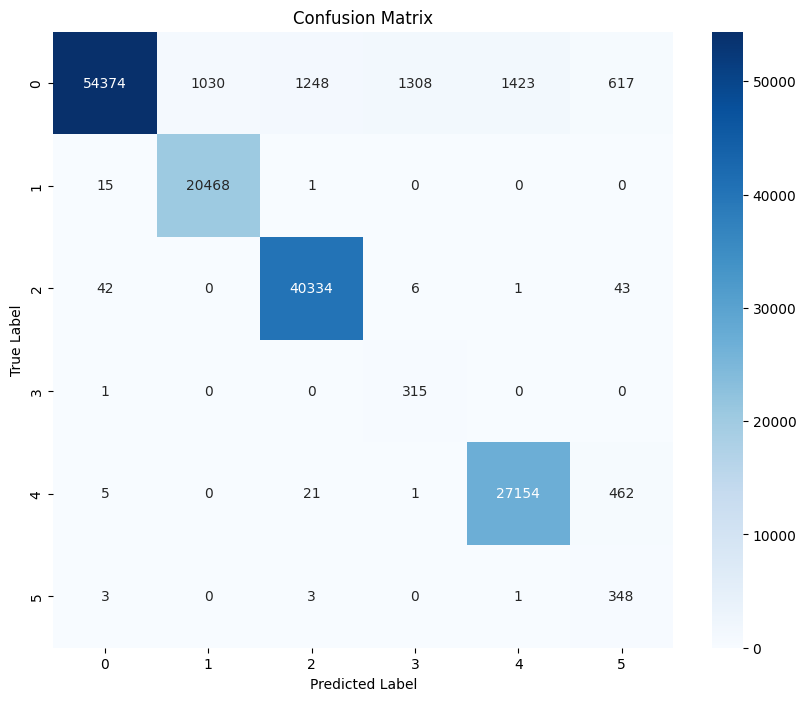

4664/4664 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9583 - loss: 0.1284
Test accuracy: 0.9582


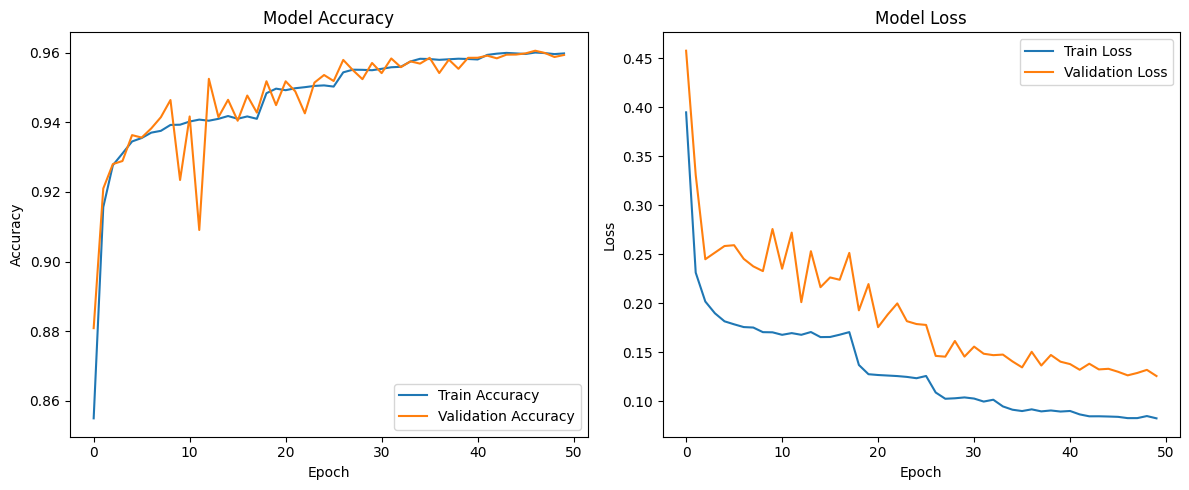

In [64]:
def main():
   
    # Preprocess data
    X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(X_scaled, y)
    
    # Get input shape for the model
    input_shape = (X_train.shape[1], X_train.shape[2])
    num_classes = len(np.unique(y))
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")
    print(f"Test set shape: {X_test.shape}")
    print(f"Number of classes: {num_classes}")
    
    # Check for class imbalance
    class_counts = np.bincount(y_train)
    print("Class distribution in training set:", class_counts)
    
    # Train the model
    model, history = train_model(
        X_train, y_train, X_val, y_val, 
        input_shape, num_classes,
        # Set use_focal_loss=True for imbalanced datasets
    )
    
    # Evaluate and visualize results
    evaluate_model(model, X_test, y_test)
    plot_training_history(history)

if __name__ == "__main__":
    main()
